In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import RobustScaler, StandardScaler
from tqdm import tqdm 

import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import sys
import shap

sys.path.append(os.path.abspath(".."))
from utils.data_utils import remove_label, process_cat_vars


In [30]:
shap.initjs()    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [3]:
def remove_label(df):
    # Extract the 'HeartDisease' column as the labels
    labels = df['HeartDisease'].copy()
    
    # Remove the 'HeartDisease' column from the dataframe
    df_without_heart_disease = df.drop(columns=['HeartDisease'])
    
    # Return the modified DataFrame and the labels
    return df_without_heart_disease, labels

def process_cat_vars(df):
    """
    Function to preprocess the data, including encoding categorical variables and 
    applying one-hot encoding to certain columns. This function is designed to be applied
    to both the training and test sets.
    
    Parameters:
    df (DataFrame): The input dataframe containing the features and the target label.

    Returns:
    DataFrame: The preprocessed dataframe
    """
    # Encode categorical variables
    # Male is 1, female is 0 for 'Sex'
    df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
    
    # 'ExerciseAngina' : Yes is 1 and No is 0
    df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})
    
    # 'ST_Slope': Up is 1, Flat is 0, Down is -1
    df['ST_Slope'] = df['ST_Slope'].map({'Up': 1, 'Flat': 0, 'Down': -1})

    # One hot encoding for categorical columns that have more than two categories
    df_encoded = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG'], dtype=int)
    
    return df_encoded

def handle_outliers(df):
     # Set outlier cholesterol values to NaN
    df.loc[df['Cholesterol'] < 50, 'Cholesterol'] = np.nan
    df.loc[df['Cholesterol'] > 400, 'Cholesterol'] = np.nan

    # Set outlier resting BP values to NaN
    df.loc[df['RestingBP'] < 30, 'RestingBP'] = np.nan

    return df.copy()

def pre_process(df):
    df = process_cat_vars(df)
    return handle_outliers(df)

In [56]:
df_train = pd.read_csv(os.path.join('train_val_split.csv'))
df_test = pd.read_csv(os.path.join('test_split.csv'))

# Data Exploration and Visualization

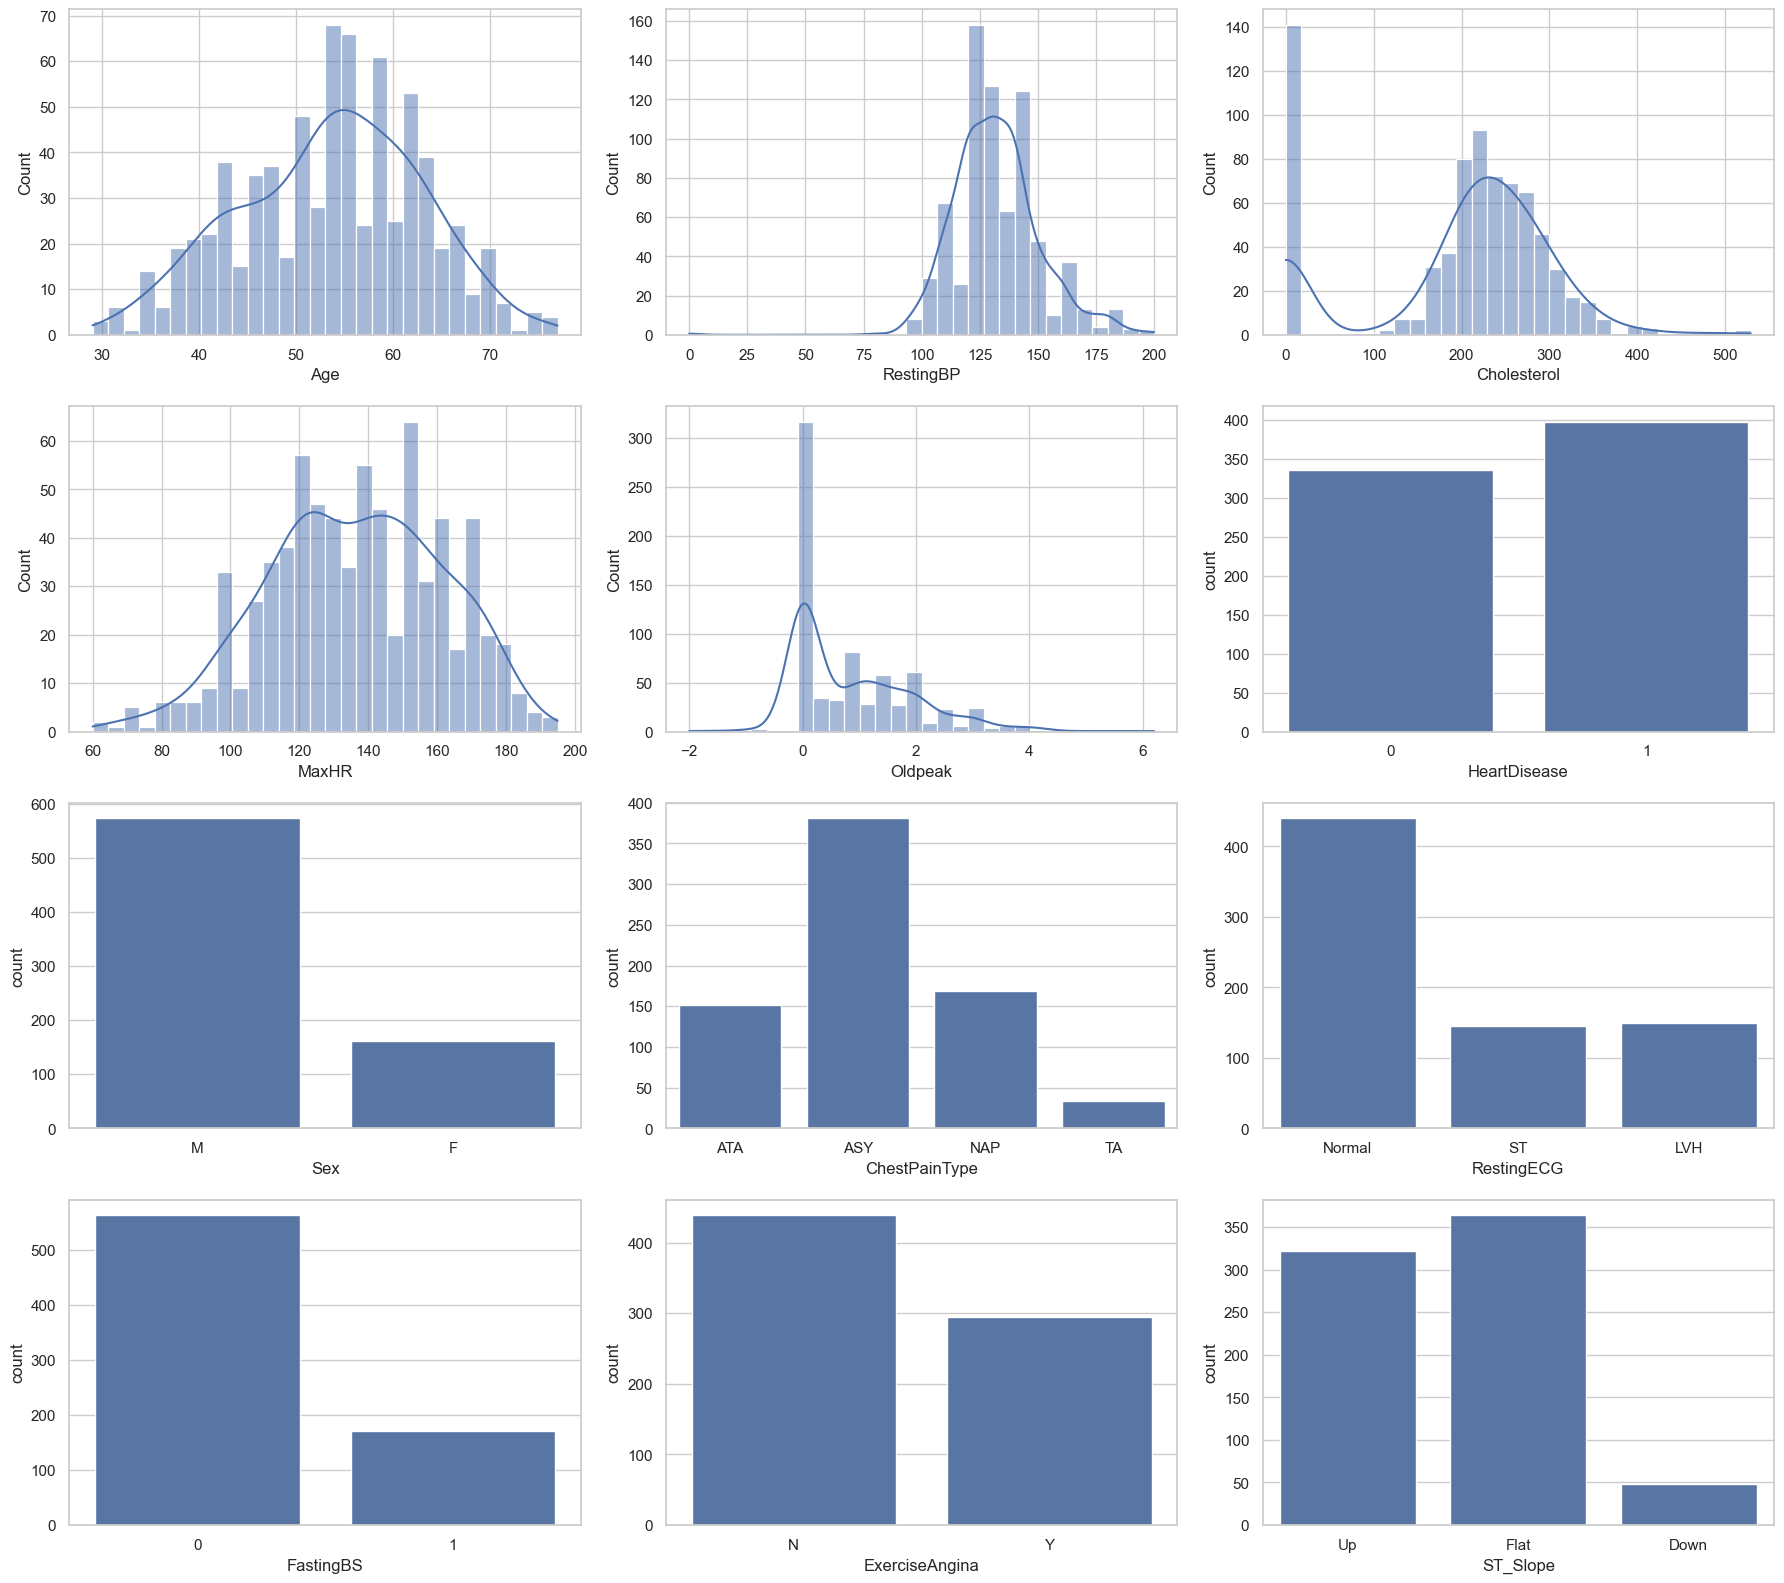

HeartDisease labels for entries with Cholesterol = 0:
HeartDisease
1    125
0     16
Name: count, dtype: int64

HeartDisease labels for entries with RestingBP = 0:
HeartDisease
1    1
Name: count, dtype: int64


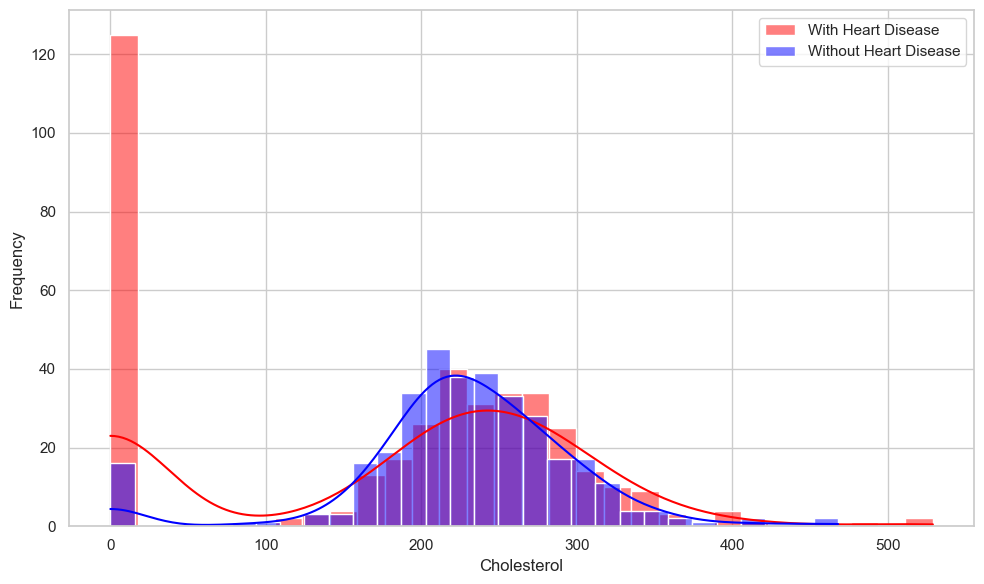

In [9]:
def plot_hists(df):
    """
    Function to plot distributions for numerical and categorical features in the dataset.
    
    Parameters:
    df (DataFrame): The input dataframe containing the data to be visualized.
    """
    # Set up the plots
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(4, 3, figsize=(18, 16))
    axs = axs.flatten()

    # Plot distributions for numerical features
    numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
    for i, feature in enumerate(numerical_features):
        sns.histplot(df[feature], kde=True, ax=axs[i], bins=30)

    # Plot distributions for categorical features
    categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'FastingBS', 'ExerciseAngina', 'ST_Slope']
    for i, feature in enumerate(categorical_features, start=6):
        sns.countplot(x=feature, data=df, ax=axs[i])

    # Plot class balance (HeartDisease label distribution)
    sns.countplot(x='HeartDisease', data=df, ax=axs[5])

    plt.tight_layout()
    plt.show()


plot_hists(df_train)


# -----------------
# Handling outliers
# -----------------

## Identiy outliers

# Checking HeartDisease labels where Cholesterol is 0
cholst0 = df_train[df_train['Cholesterol'] == 0]
cholst0_summary = cholst0['HeartDisease'].value_counts()

# Checking HeartDisease labels where RestingBP is 0
Rbp_0 = df_train[df_train['RestingBP'] == 0]
Rbp_0_summary = Rbp_0['HeartDisease'].value_counts()

print("HeartDisease labels for entries with Cholesterol = 0:")
print(cholst0_summary)

print("\nHeartDisease labels for entries with RestingBP = 0:")
print(Rbp_0_summary)

# Plot cholesterol values by HeartDisease labels

disease_df = df_train[df_train['HeartDisease'] == 1]
no_disease_df = df_train[df_train['HeartDisease'] == 0]

# Set up the plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the distribution for patients with heart disease
sns.histplot(disease_df['Cholesterol'], kde=True, color='red', bins=30, label='With Heart Disease')

# Plot the distribution for patients without heart disease
sns.histplot(no_disease_df['Cholesterol'], kde=True, color='blue', bins=30, label='Without Heart Disease')

# Adding title and labels
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')

# Show legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


# Data Preprocessing

In [57]:
X_train, Y_train = remove_label(df_train)
X_test, Y_test = remove_label(df_test)

In [58]:
df_train_nlp = X_train.copy()
df_test_nlp = X_test.copy()

In [39]:
X_train = pre_process(X_train)
X_test = pre_process(X_test)
X_train.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,1,140.0,289.0,0,172,0,0.0,1,0,1,0,0,0,1,0
1,37,1,130.0,283.0,0,98,0,0.0,1,0,1,0,0,0,0,1
2,48,0,138.0,214.0,0,108,1,1.5,0,1,0,0,0,0,1,0
3,54,1,150.0,195.0,0,122,0,0.0,1,0,0,1,0,0,1,0
4,39,1,120.0,339.0,0,170,0,0.0,1,0,0,1,0,0,1,0


In [40]:
cholesterol_median = X_train['Cholesterol'].median()
restingbp_median = X_train['RestingBP'].median()

X_train['Cholesterol'] = X_train['Cholesterol'].fillna(cholesterol_median)
X_train['RestingBP'] = X_train['RestingBP'].fillna(restingbp_median)

X_test['Cholesterol'] = X_test['Cholesterol'].fillna(cholesterol_median)
X_test['RestingBP'] = X_test['RestingBP'].fillna(restingbp_median)

In [42]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
X_train_scaled

array([[-1.07692308,  0.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-1.30769231,  0.        ,  0.        , ...,  0.        ,
        -1.        ,  1.        ],
       [-0.46153846, -1.        ,  0.4       , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.69230769,  0.        , -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.07692308,  0.        ,  0.7       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.23076923,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# Logistic Regression
Fit a Lasso Regression Model with L1 Regularization

              Feature  Coefficient
0                 Age     0.314137
1                 Sex     1.557834
2           RestingBP     0.000000
3         Cholesterol     0.235711
4           FastingBS     0.997659
5               MaxHR    -0.344251
6      ExerciseAngina     0.925489
7             Oldpeak     0.541319
8            ST_Slope    -1.540157
9   ChestPainType_ASY     1.387503
10  ChestPainType_ATA    -0.647399
11  ChestPainType_NAP    -0.082329
12   ChestPainType_TA     0.000000
13     RestingECG_LVH     0.000000
14  RestingECG_Normal     0.128724
15      RestingECG_ST     0.000000
F1 Score: 0.857
Balanced Accuracy: 0.815
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        74
           1       0.84      0.87      0.86       110

    accuracy                           0.83       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.83      0.83      0.83       184



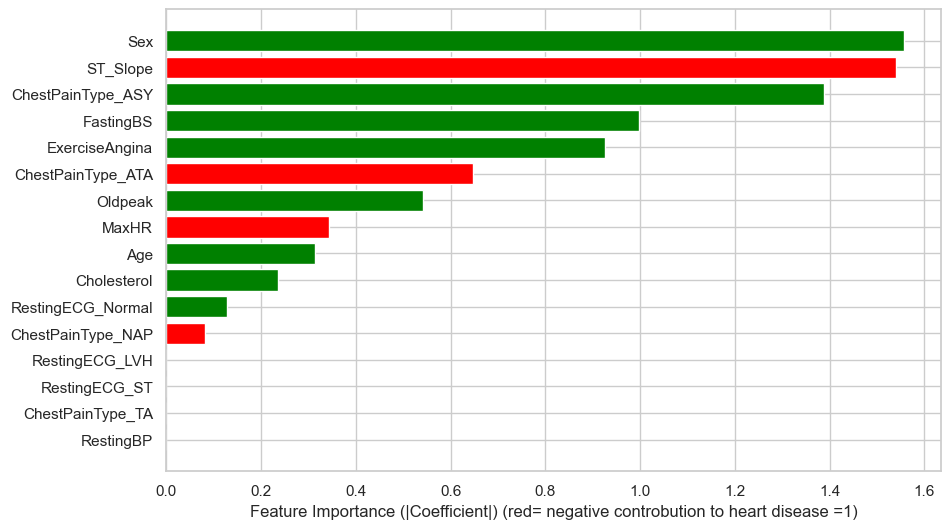

In [17]:
# Fit the Lasso regression model
#lasso = Lasso(alpha=0.3)
#lasso.fit(X_train_scaled, Y_train)
log_lasso_model = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=30)  # C is the inverse of alpha
log_lasso_model.fit(X_train_scaled, Y_train)
coefficients = log_lasso_model.coef_.flatten()

coefficients.size


# Print coefficients and corresponding column names
feature_names = X_train.columns
feature_names.size
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(coefficients_df)

# Predictions
y_pred_binary = log_lasso_model.predict(X_test_scaled)

# Q2.3: Quantify the Performance of the Model
# Compute F1-Score
f1 = f1_score(Y_test, y_pred_binary)
# Compute Balanced Accuracy
balanced_accuracy = balanced_accuracy_score(Y_test, y_pred_binary)

# Print metrics
print(f"F1 Score: {f1:.3f}")
print(f"Balanced Accuracy: {balanced_accuracy:.3f}")

# Detailed classification report
print(classification_report(Y_test, y_pred_binary))

# Q2.4: Visualize the Feature Importance
# Plot feature importance (absolute value of coefficients)

# Calculate importance and sort
feature_importance = np.abs(coefficients)
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_coefficients = coefficients[sorted_idx]
sorted_features = feature_names[sorted_idx]

# Assign colors based on sign
colors = ['green' if coef > 0 else 'red' for coef in sorted_coefficients]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, feature_importance[sorted_idx], align='center', color=colors)
plt.xlabel('Feature Importance (|Coefficient|) (red= negative controbution to heart disease =1)')
plt.gca().invert_yaxis()  # optional: highest importance on top
plt.savefig('P1_Q2_lasso_feat_imp_plot.png', dpi=300, bbox_inches='tight')

# NAM

In [18]:
class ActivationLayer(nn.Module):
    def __init__(self, input_dim, num_units, activation='relu'):
        super().__init__()
        self.activation = activation
        if activation == 'relu':
            self.linear = nn.Linear(input_dim, num_units)
        elif activation == 'exu':
            self.beta = nn.Parameter(torch.empty(input_dim, num_units))
            self.c = nn.Parameter(torch.empty(1, num_units))
            nn.init.trunc_normal_(self.beta, mean=4.0, std=0.5)
            nn.init.trunc_normal_(self.c, std=0.5)
        else:
            raise ValueError("Unsupported activation type. Use 'relu' or 'exu'.")

    def forward(self, x):
        if self.activation == 'relu':
            return F.relu(self.linear(x))
        elif self.activation == 'exu':
            center = self.c.expand(x.shape[0], -1)
            return torch.clamp(torch.exp(self.beta) * (x - center), 0, 1)

# FeatureNN using ExU and additional dense layers (shallow = False)
class FeatureNN(nn.Module):
    def __init__(self, num_units, feature_idx, activation='relu'):
        super().__init__()
        self.activation = ActivationLayer(1, num_units, activation=activation)
        self.hidden1 = nn.Linear(num_units, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.linear = nn.Linear(32, 1, bias=False)
        self.feature_idx = feature_idx

    def forward(self, x):
        x = x[:, self.feature_idx].unsqueeze(1)  # [batch_size, 1]
        x = self.activation(x)                  # [batch_size, num_units]
        x = F.relu(self.hidden1(x))             # [batch_size, 64]
        x = F.relu(self.hidden2(x))             # [batch_size, 32]
        x = self.linear(x)                      # [batch_size, 1]
        return x.squeeze(1)                     # [batch_size]

# NAM model
class NAM(nn.Module):
    def __init__(self, input_dim, num_units=64, activation='relu'):
        super().__init__()
        self.feature_nns = nn.ModuleList([
            FeatureNN(num_units=num_units, feature_idx=i, activation=activation) for i in range(input_dim)
        ])
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        outputs = [fnn(x) for fnn in self.feature_nns]  # list of [batch_size]
        return torch.sigmoid(torch.stack(outputs, dim=1).sum(dim=1) + self.bias)


In [19]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, lr=0.001, batch_size=64):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    pos_weight = torch.tensor([Y_train.value_counts()[0] / Y_train.value_counts()[1]], dtype=torch.float32)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        with torch.no_grad():
            val_preds = torch.cat([model(xb.to(device)) for xb, _ in val_loader]).cpu().numpy()
            val_labels = torch.cat([yb for _, yb in val_loader]).numpy()
            val_preds_binary = (val_preds >= 0.5).astype(int)
            acc = accuracy_score(val_labels, val_preds_binary)
            f1 = f1_score(val_labels, val_preds_binary)
            print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={acc:.4f}, F1={f1:.4f}")

    return model

# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(X_tensor).cpu().numpy()
    preds_binary = (preds >= 0.5).astype(int)
    acc = accuracy_score(y_test, preds_binary)
    f1 = f1_score(y_test, preds_binary)
    bal_acc = balanced_accuracy_score(y_test, preds_binary)
    print(f"Test Accuracy: {acc:.4f}, F1-score: {f1:.4f}, Balanced Accuracy: {bal_acc:.4f}")
    return #preds
    
# Visualization of learned feature functions
def plot_feature_functions(model, feature_names, X):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fig, axes = plt.subplots(len(feature_names)//2, 2, figsize=(12, len(feature_names)*2))
    axes = axes.flatten()
    for i, (name, fnn) in enumerate(zip(feature_names, model.feature_nns)):
        print(name)
        vals = torch.linspace(X[:, i].min(), X[:, i].max(), steps=100).to(device)
        input_matrix = torch.zeros((100, X.shape[1]), device=device)
        input_matrix[:, i] = vals
        with torch.no_grad():
            out = fnn(input_matrix).cpu().numpy()
        axes[i].plot(vals.cpu().numpy(), out)
        axes[i].set_title(name)
        axes[i].set_xlabel(f"{name} value")
        axes[i].set_ylabel("Contribution to logit")
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, X, feature_names):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        contributions = []
        for i, fnn in enumerate(model.feature_nns):
            out = fnn(X_tensor).cpu().numpy()
            abs_mean = np.mean(np.abs(out))  # mean absolute contribution
            contributions.append(abs_mean)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(feature_names)), contributions, color='orangered', label='NAMs')
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.ylabel("Mean Absolute Score")
    plt.title("Overall Importance")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [20]:
model = NAM(input_dim=X_train_scaled.shape[1], num_units=64, activation='exu')

C:\Users\salom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\init.py:224: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b, generator=generator)


In [21]:
trained_model = train_model(model, X_train_scaled, Y_train, X_test_scaled, Y_test, epochs=40)

Epoch 1: Loss=0.6148, Accuracy=0.7663, F1=0.7749
Epoch 2: Loss=0.5634, Accuracy=0.7880, F1=0.8060
Epoch 3: Loss=0.5398, Accuracy=0.8098, F1=0.8357
Epoch 4: Loss=0.5312, Accuracy=0.8098, F1=0.8341
Epoch 5: Loss=0.5277, Accuracy=0.8261, F1=0.8505
Epoch 6: Loss=0.5248, Accuracy=0.8207, F1=0.8465
Epoch 7: Loss=0.5231, Accuracy=0.8261, F1=0.8519
Epoch 8: Loss=0.5215, Accuracy=0.8370, F1=0.8598
Epoch 9: Loss=0.5210, Accuracy=0.8315, F1=0.8545
Epoch 10: Loss=0.5198, Accuracy=0.8261, F1=0.8491
Epoch 11: Loss=0.5184, Accuracy=0.8370, F1=0.8611
Epoch 12: Loss=0.5181, Accuracy=0.8424, F1=0.8676
Epoch 13: Loss=0.5166, Accuracy=0.8533, F1=0.8767
Epoch 14: Loss=0.5155, Accuracy=0.8370, F1=0.8611
Epoch 15: Loss=0.5146, Accuracy=0.8315, F1=0.8584
Epoch 16: Loss=0.5147, Accuracy=0.8370, F1=0.8585
Epoch 17: Loss=0.5133, Accuracy=0.8261, F1=0.8532
Epoch 18: Loss=0.5136, Accuracy=0.8207, F1=0.8479
Epoch 19: Loss=0.5125, Accuracy=0.8315, F1=0.8531
Epoch 20: Loss=0.5113, Accuracy=0.8261, F1=0.8491
Epoch 21:

In [22]:
evaluate_model(trained_model, X_test_scaled, Y_test)

Test Accuracy: 0.8261, F1-score: 0.8545, Balanced Accuracy: 0.8192


Age
Sex
RestingBP
Cholesterol
FastingBS
MaxHR
ExerciseAngina
Oldpeak
ST_Slope
ChestPainType_ASY
ChestPainType_ATA
ChestPainType_NAP
ChestPainType_TA
RestingECG_LVH
RestingECG_Normal
RestingECG_ST


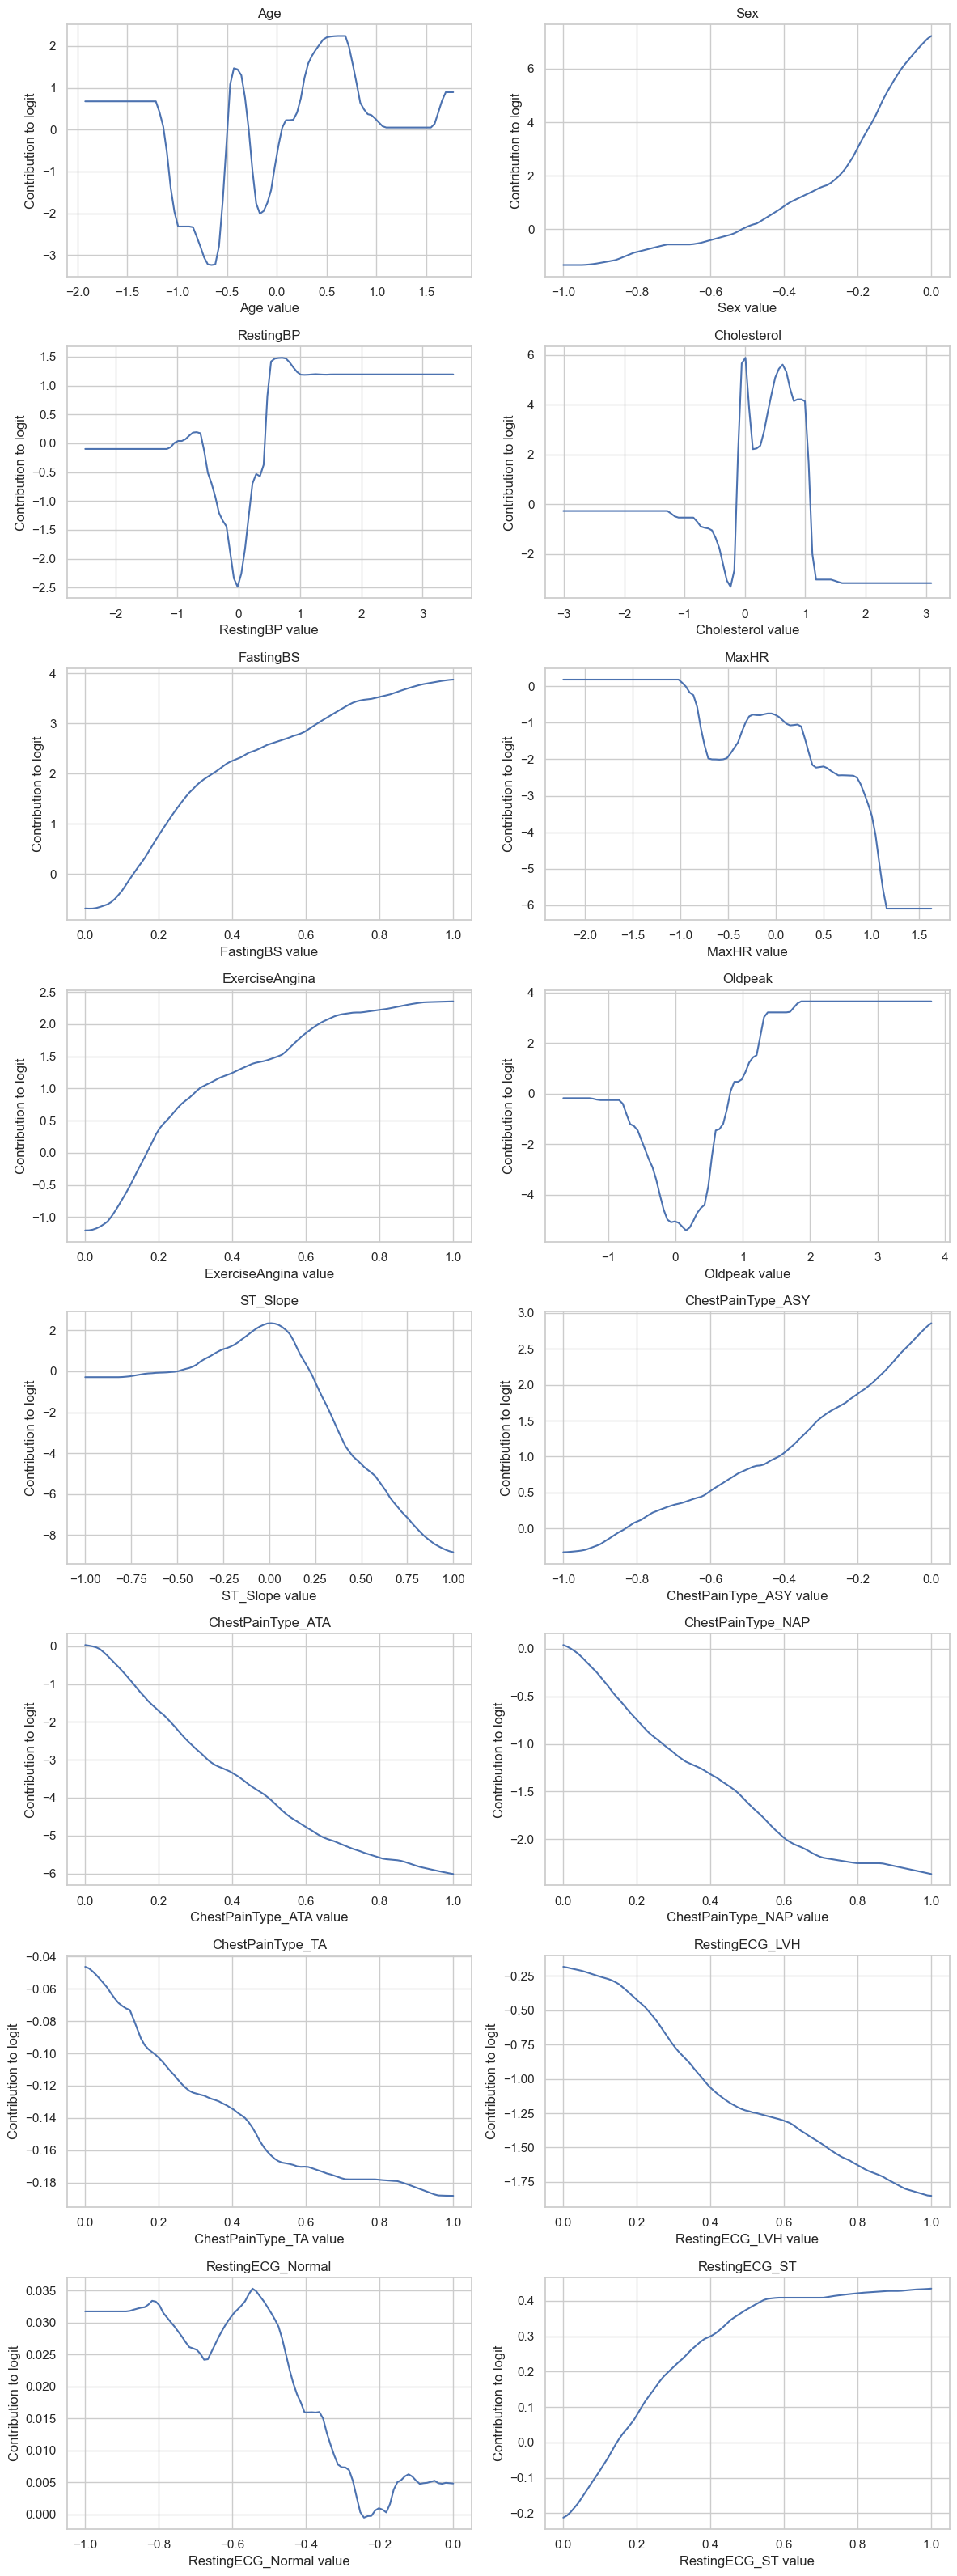

In [23]:
plot_feature_functions(trained_model, X_train.columns.tolist(), X_train_scaled)

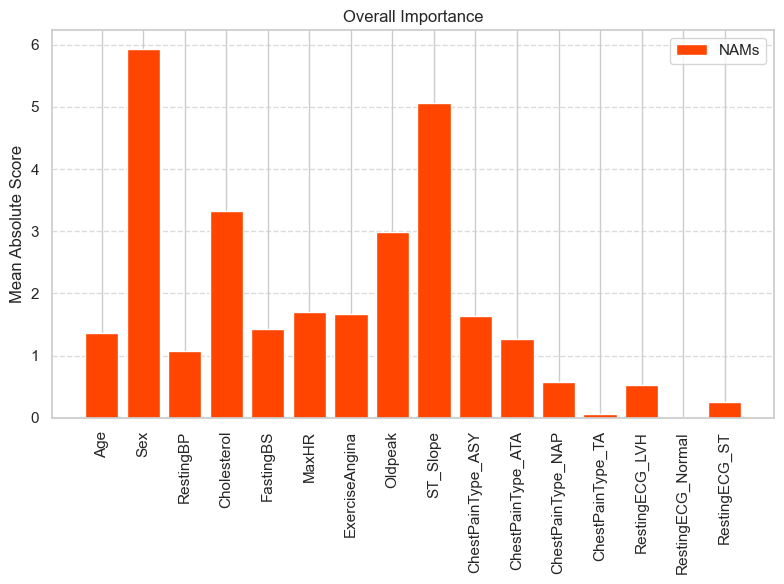

In [24]:
plot_feature_importance(trained_model, X_train_scaled, X_train.columns.tolist())

# MLP

In [59]:
df_train_nlp = process_cat_vars(df_train_nlp)
df_test_nlp = process_cat_vars(df_test_nlp)

X_train = torch.tensor(df_train_nlp.values, dtype=torch.float32).to(device)
y_train = torch.tensor(Y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(df_test_nlp.values, dtype=torch.float32).to(device)
y_test = torch.tensor(Y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

## Ensure that it worked

In [60]:
print("Train set shape:", df_train_nlp.shape)
df_train_nlp.head()

Train set shape: (734, 16)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,1,140,289,0,172,0,0.0,1,0,1,0,0,0,1,0
1,37,1,130,283,0,98,0,0.0,1,0,1,0,0,0,0,1
2,48,0,138,214,0,108,1,1.5,0,1,0,0,0,0,1,0
3,54,1,150,195,0,122,0,0.0,1,0,0,1,0,0,1,0
4,39,1,120,339,0,170,0,0.0,1,0,0,1,0,0,1,0


In [61]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu1 = torch.nn.ReLU()
        #self.relu2 = torch.nn.ReLU()
        #self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        #x = self.fc2(x)
        #x = self.relu2(x)
        x = self.fc3(x)
        return x

model = MLP(input_size=df_train_nlp.shape[1], hidden_size=64, output_size=1).to(device)

Epochs: 100%|██████████| 100/100 [00:01<00:00, 50.89epoch/s]


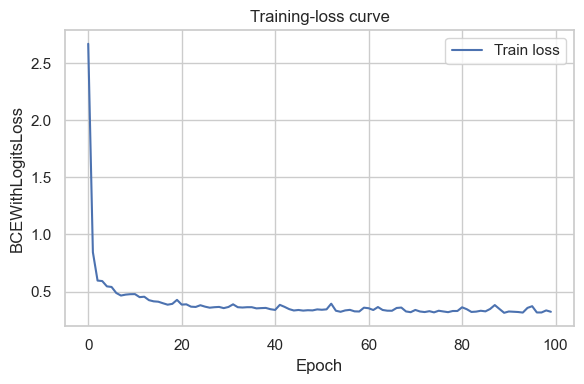

In [62]:
batch_size = 32
learning_rate = 0.001
num_epochs = 100
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader  = DataLoader(train_dataset,
                           batch_size=batch_size,
                           shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion  = torch.nn.BCEWithLogitsLoss()

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

loss_history = []

for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs", unit="epoch"):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
       

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)

    #scheduler.step()    

plt.figure(figsize=(6, 4))          
plt.plot(loss_history, label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogitsLoss")
plt.title("Training-loss curve")
plt.grid(True)
plt.legend()
plt.tight_layout()             
plt.show()


In [68]:
from sklearn.metrics import f1_score
batch_size = 1

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader  = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=False)


all_logits = []
all_labels = []
test_running_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        logits = model(X_batch)                      
        loss   = criterion(logits, y_batch)

        test_running_loss += loss.item() * X_batch.size(0)

        all_logits.append(logits.cpu())
        all_labels.append(y_batch.cpu())

test_loss = test_running_loss / len(test_loader.dataset)
logits  = torch.cat(all_logits).squeeze()        
targets = torch.cat(all_labels).squeeze()         

probs = torch.sigmoid(logits)                   
preds = (probs >= 0.5).int() 
f1  = f1_score(targets.numpy(), preds.numpy())
bal = balanced_accuracy_score(targets.numpy(), preds.numpy())   # add this

print(f"Average test loss: {test_loss:.4f}")
print(f"Test F1 score   : {f1:.4f}")
print(f"Balanced ACC    : {bal:.4f}")     
accuracy = (preds == targets).float().mean()                
print(f"Test accuracy   : {accuracy:.4f}")

Average test loss: 0.4353
Test F1 score   : 0.8522
Balanced ACC    : 0.7968
Test accuracy   : 0.8152


C:\Users\salom\AppData\Local\Temp\ipykernel_27096\2510645764.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


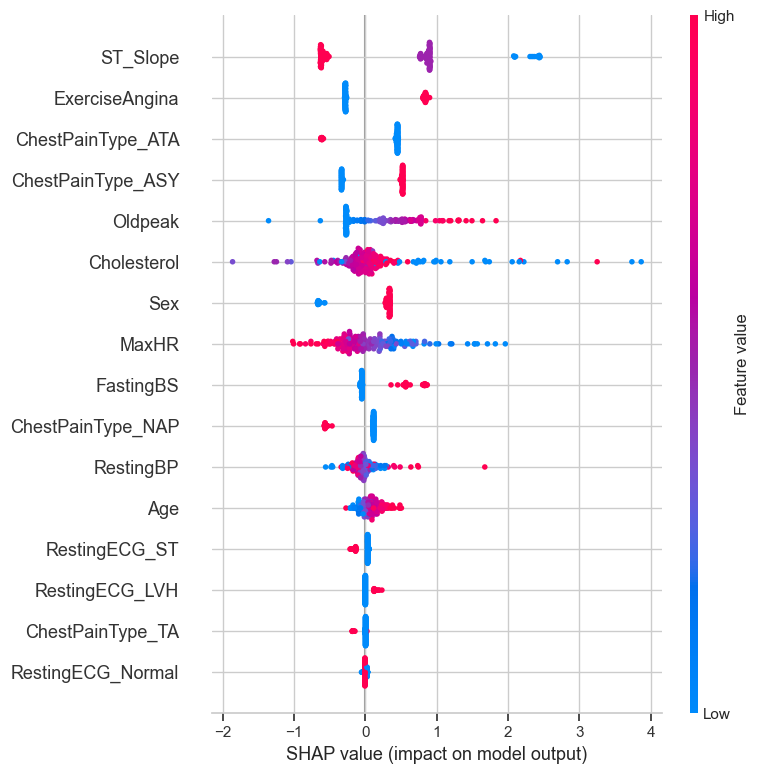

In [70]:
model.eval()

background = X_train[:100]   
explainer = shap.DeepExplainer(model, background)
data = X_test
shap_vals = explainer.shap_values(data).squeeze()
shap.summary_plot(
    shap_vals,
    data.cpu().numpy(),         
    feature_names=df_train_nlp.columns,
    plot_type="dot",
    show=True,
); 

In [71]:
positive_indices = [i for i, x in enumerate(y_test) if x == 1][:2]
negative_indices = [i for i, x in enumerate(y_test) if x == 0][:2]

print("Positive indices:", positive_indices)
print("Negative indices:", negative_indices)

Positive indices: [0, 1]
Negative indices: [6, 10]


## Positives

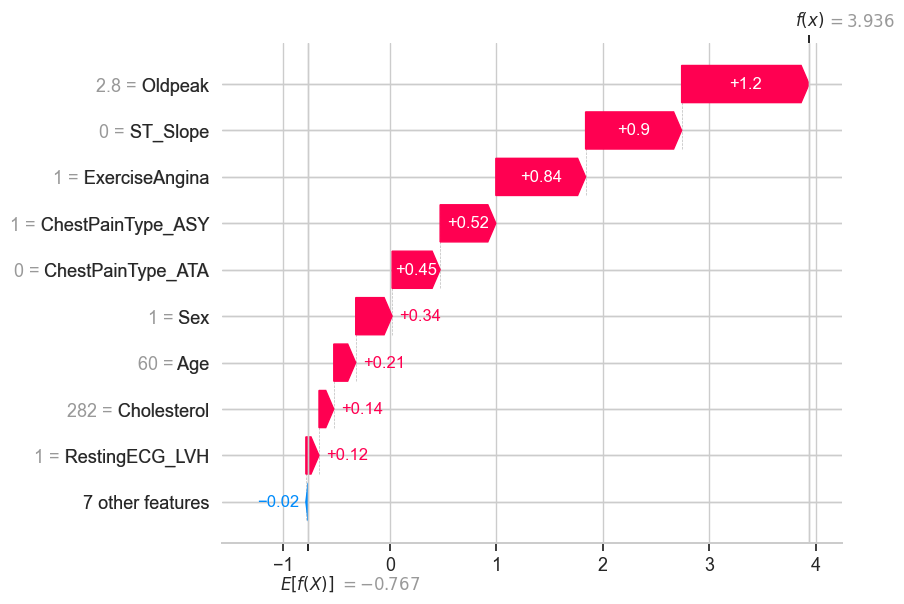

In [74]:
i = 0
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= df_train_nlp.columns.tolist()
        ),
        max_display=10, show=True
    )

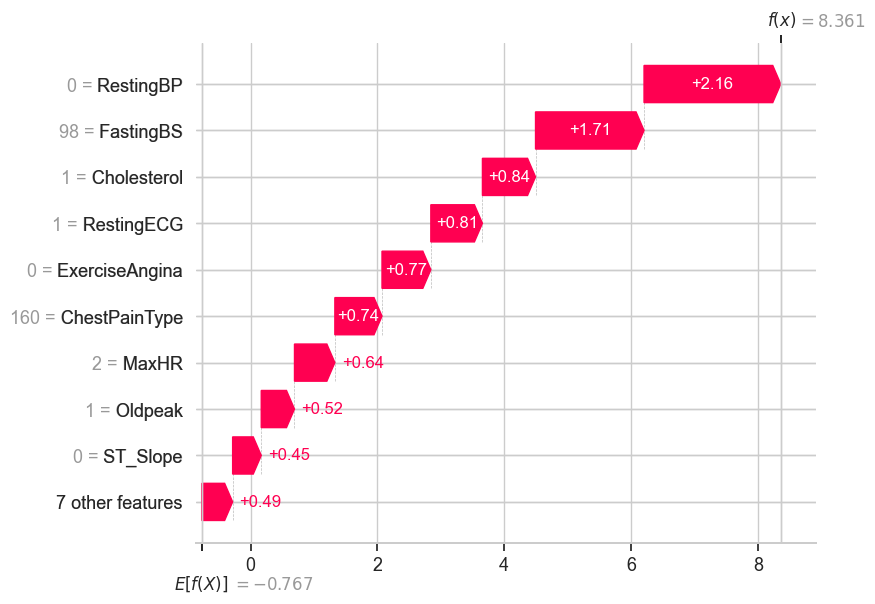

In [75]:
i = 1
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= df_train.columns.tolist()
        ),
        max_display=10, show=True
    )

## Negatives

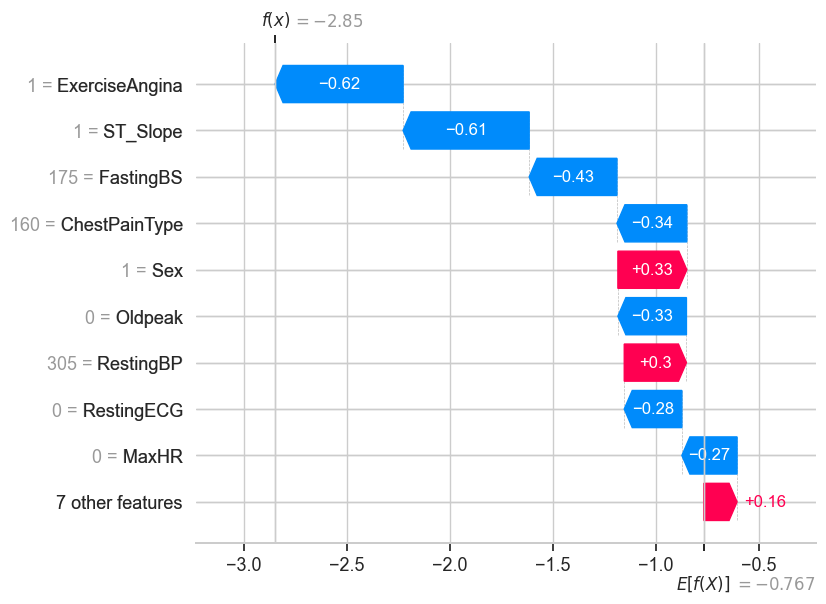

In [76]:
i = 6
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= df_train.columns.tolist()
        ),
        max_display=10, show=True
    )

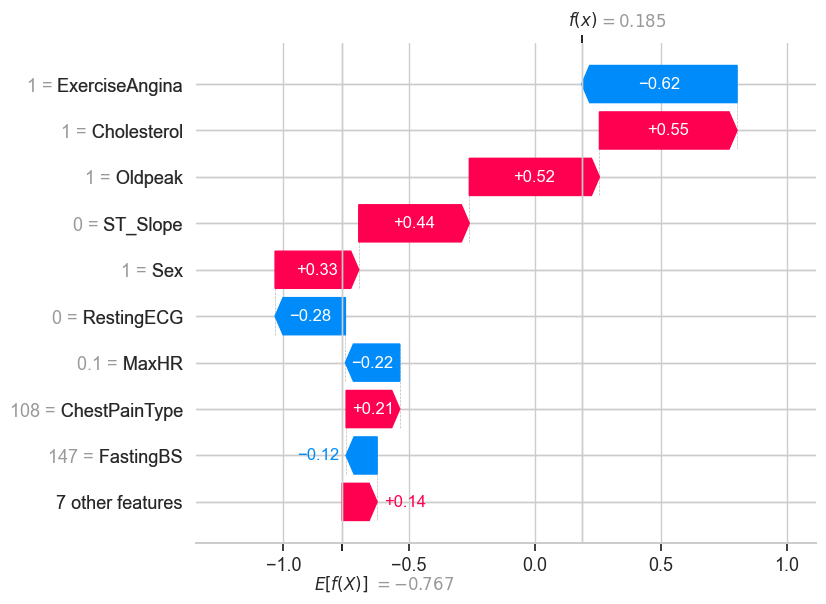

In [77]:
i = 10
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= df_train.columns.tolist()
        ),
        max_display=10, show=True
    )